In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
import xscale as xsc
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.38:41017 Dashboard: http://10.148.0.38:8787/status,Cluster Workers: 70 Cores: 70 Memory: 1.09 TiB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')

In [8]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [9]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC           (lat, lon_g) float32 1.568e+03 1.568e+03 ... 1.489e+03
    dyG           (lat, lon_g) float32 1.469e+03 1.469e+03 ... 1.403e+03
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06
    ...            ...
    XC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rA            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    XG            (lat_g, lon_g) float32 ...
    YG            (lat_g, lon_g) float32 ...
    rAz           (lat_g, lon_g) float32 ...
Data 

_______
# 2. Vertical gradient

## 2.1 db/dz (i.e., $N^2$)
### note that -1* is necessary to make the sign correct ####

In [11]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
print(db_dz)

<xarray.DataArray 'mul-1293b8e6e9fbd5f64a39c7cfbfe0560d' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


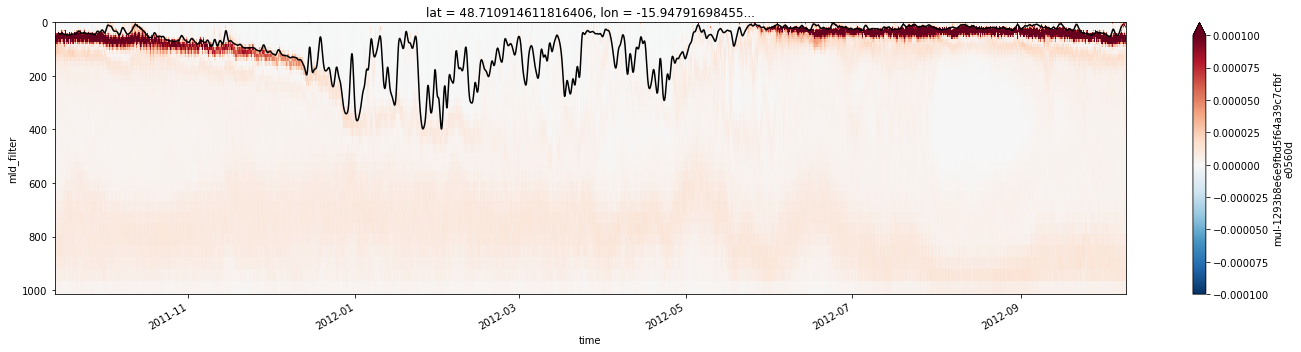

In [12]:
fig = plt.figure(figsize=(24,5))
db_dz.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.0001,vmax=0.0001,cmap='RdBu_r', yincrease=False) # lat=100 & lon=100 is a location near the mooring site
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 2.2 du/dz

In [13]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-25b4b814ad5701d4d8841f7247747b69' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


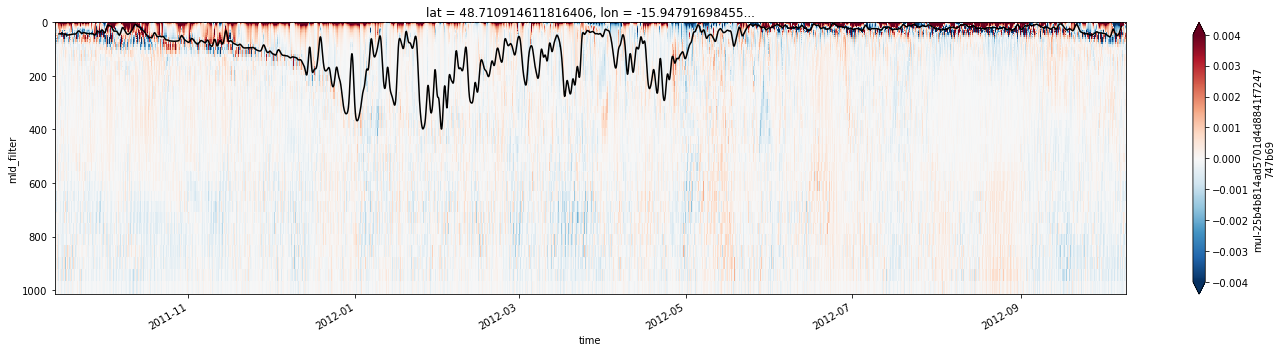

In [14]:
fig = plt.figure(figsize=(24,5))
dU_dz_ij.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.004,vmax=0.004,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

____________
# 3. Geostrphic shear production (GSP)

## $GSP = -\overline{u_h'w'} \cdot (\partial \overline{u_h}/\partial z)$ with $u_h = (u,v)$

## 3.1 define perturbation (e.g., u', v')

In [17]:
w_mean = ds.W.mean(['lat','lon']) # spatial mean
b_mean = ds.Buoy.mean(['lat','lon'])
u_mean = ds.U.mean(['lat','lon_g'])
v_mean = ds.V.mean(['lat_g','lon'])

w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean
u_prime = ds.U - u_mean
v_prime = ds.V - v_mean

u_prime_ij = gridx.interp(u_prime,'X') # interplate into the cell center (i, j or lon, lat)
u_prime_ij

v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')

dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')

vsp = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime * v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp

store_dir_zarr = '/home1/scratch/xyu/Energtics/'
chunks = {'time': 9415, 'depth':1}
vsp = vsp.chunk(chunks)
vsp = np.real(vsp).rename('vsp')
vsp = vsp.to_dataset()
print(vsp)
file_out = store_dir_zarr+'/vsp_rechunk.zarr'
%time vsp.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:  (depth: 52, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    dzt      (depth) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    vsp      (time, depth) float64 dask.array<chunksize=(9415, 1), meta=np.ndarray>
CPU times: user 6min, sys: 10 s, total: 6min 10s
Wall time: 6min 10s


In [18]:
w_mean = ds_filter.W_low_filter.mean(['lat','lon']) # spatial mean
b_mean = ds_filter.B_low_filter.mean(['lat','lon'])
u_mean = ds_filter.U_low_filter.mean(['lat','lon_g'])
v_mean = ds_filter.V_low_filter.mean(['lat_g','lon'])

w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean
u_prime = ds_filter.U_low_filter - u_mean
v_prime = ds_filter.V_low_filter - v_mean

u_prime_ij = gridx.interp(u_prime,'X') # interplate into the cell center (i, j or lon, lat)
u_prime_ij

v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

dU_dz_left = -1*gridx.diff(ds_filter.U_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')

dV_dz_left = -1*gridx.diff(ds_filter.V_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')

vsp_filter = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime * v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp_filter

store_dir_zarr = '/home1/scratch/xyu/Energtics/'
chunks = {'time': 9415, 'depth':1}
vsp_filter = vsp_filter.chunk(chunks)
vsp_filter = np.real(vsp_filter).rename('vsp_filter')
vsp_filter = vsp_filter.to_dataset()
print(vsp_filter)
file_out = store_dir_zarr+'/vsp_rechunk_filter.zarr'
%time vsp_filter.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:     (depth: 52, time: 9415)
Coordinates:
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    vsp_filter  (time, depth) float64 dask.array<chunksize=(9415, 1), meta=np.ndarray>


distributed.core - ERROR - 'tcp://10.148.0.244:34666'
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/core.py", line 572, in handle_stream
    handler(**merge(extra, msg))
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/scheduler.py", line 4826, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.148.0.244:34666'
distributed.utils - ERROR - 'tcp://10.148.0.244:34666'
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/scheduler.py", line 3840, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/scheduler.

KilledWorker: ("('concatenate-getitem-dc2fd5b878724e8f02e7b467fa80549f', 0, 15, 45, 0)", <Worker 'tcp://10.148.0.248:44266', name: 7-2, memory: 0, processing: 718>)

In [15]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
vsp = xr.open_zarr(store_dir_zarr+'vsp_rechunk.zarr')
vsp_filter = xr.open_zarr(store_dir_zarr+'vsp_rechunk_filter.zarr')

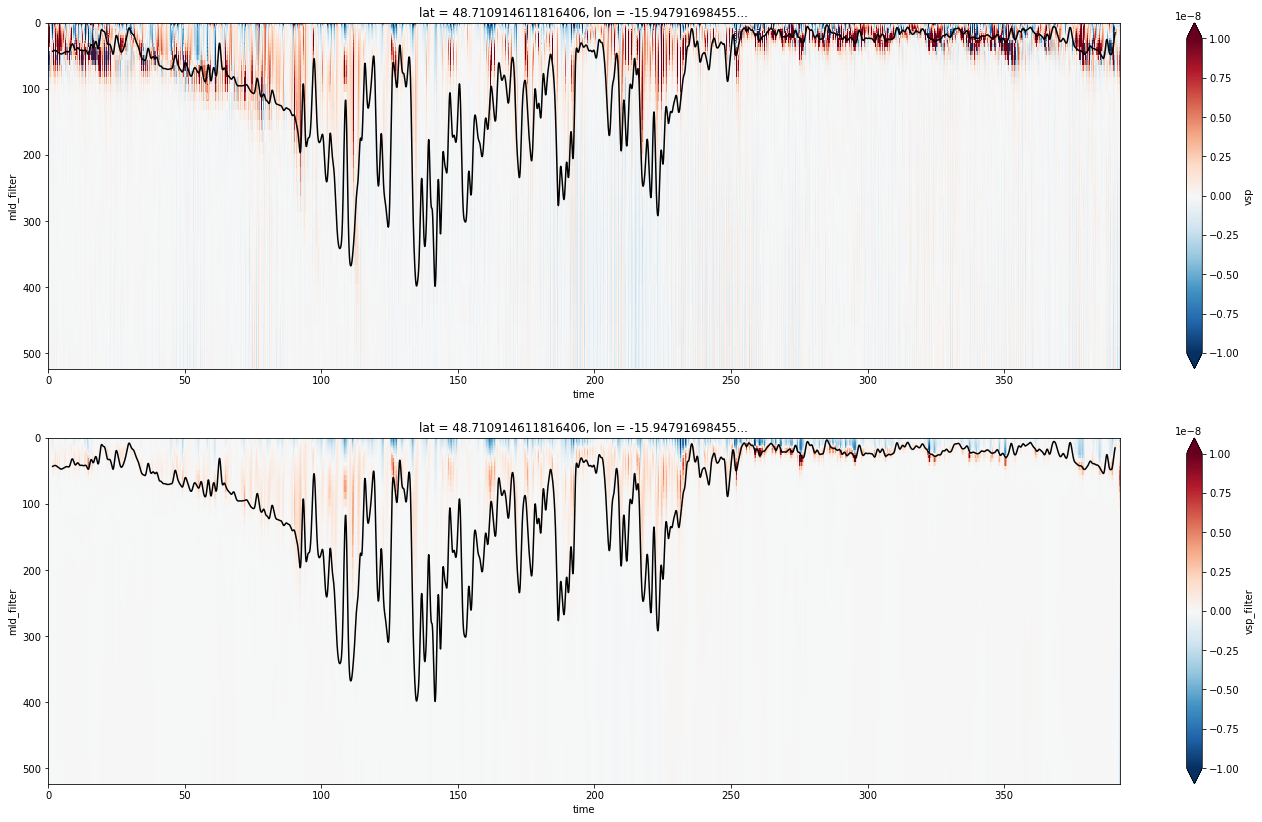

In [19]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
vsp.vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
vsp_filter.vsp_filter.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

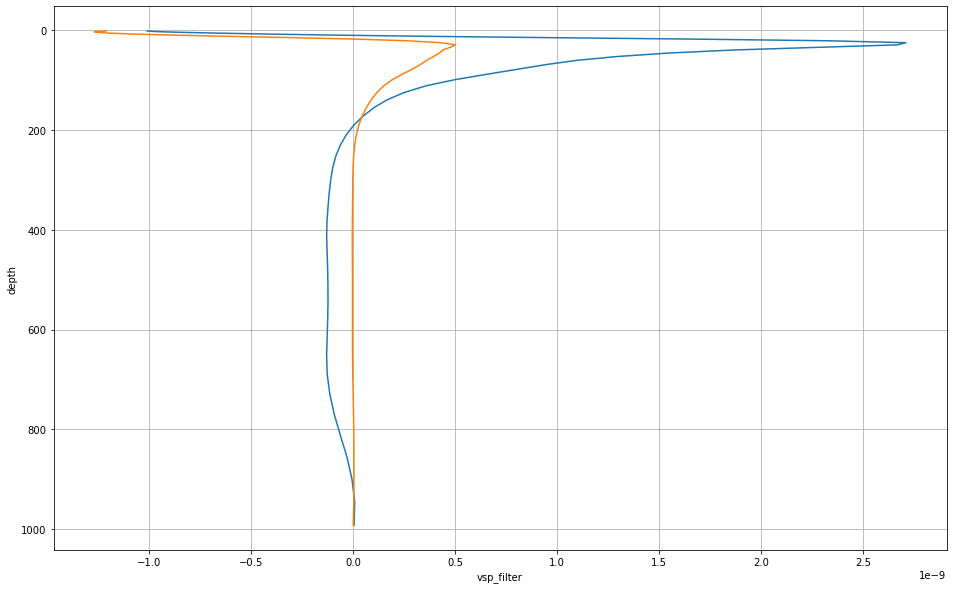

In [20]:
fig, ax = plt.subplots(figsize=(16,10))
vsp.vsp.mean('time').plot(y='depth', yincrease=False)
vsp_filter.vsp_filter.mean('time').plot(y='depth', yincrease=False)
ax.grid()

# 6. GSP vs. w'b'

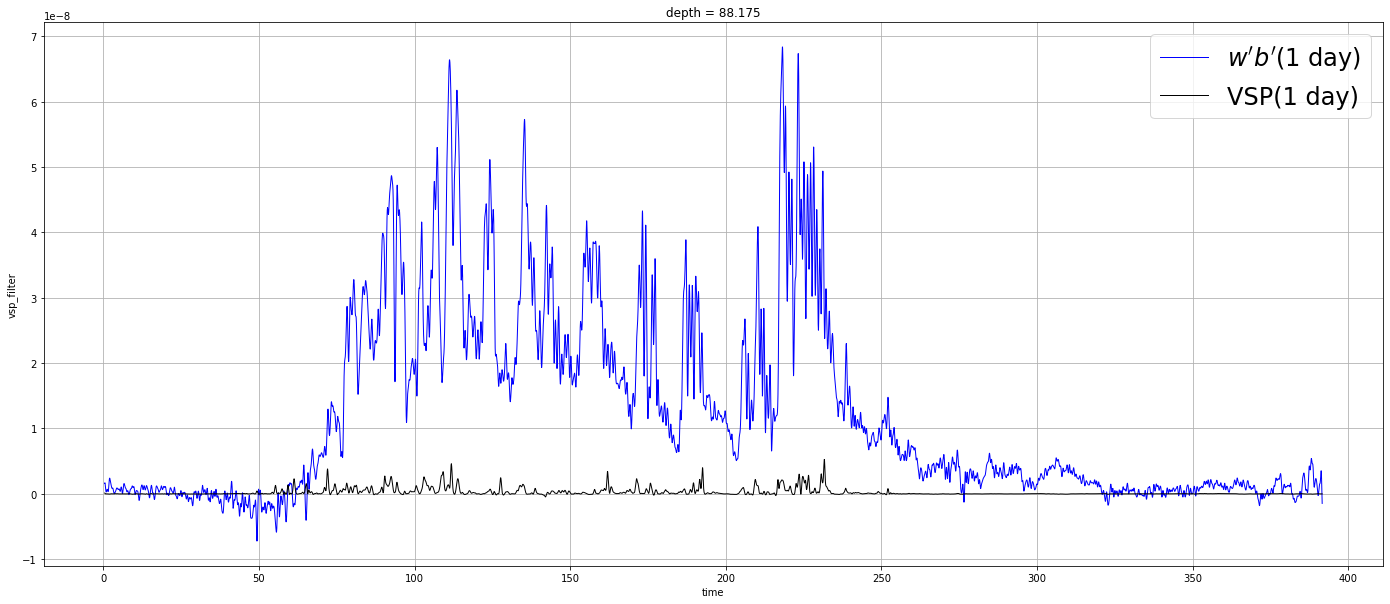

In [42]:
labels = ['VSP(1 day)', '$w^\prime b^\prime$(1 day)']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime_filter.wb_prime_filter.isel(depth=20,time=slice(10,9400)).plot(ax=ax, color='blue', label=labels[1], linewidth=1)
vsp_filter.vsp_filter.isel(depth=20,time=slice(10,9400)).plot(ax=ax, color='black', label=labels[0], linewidth=1)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

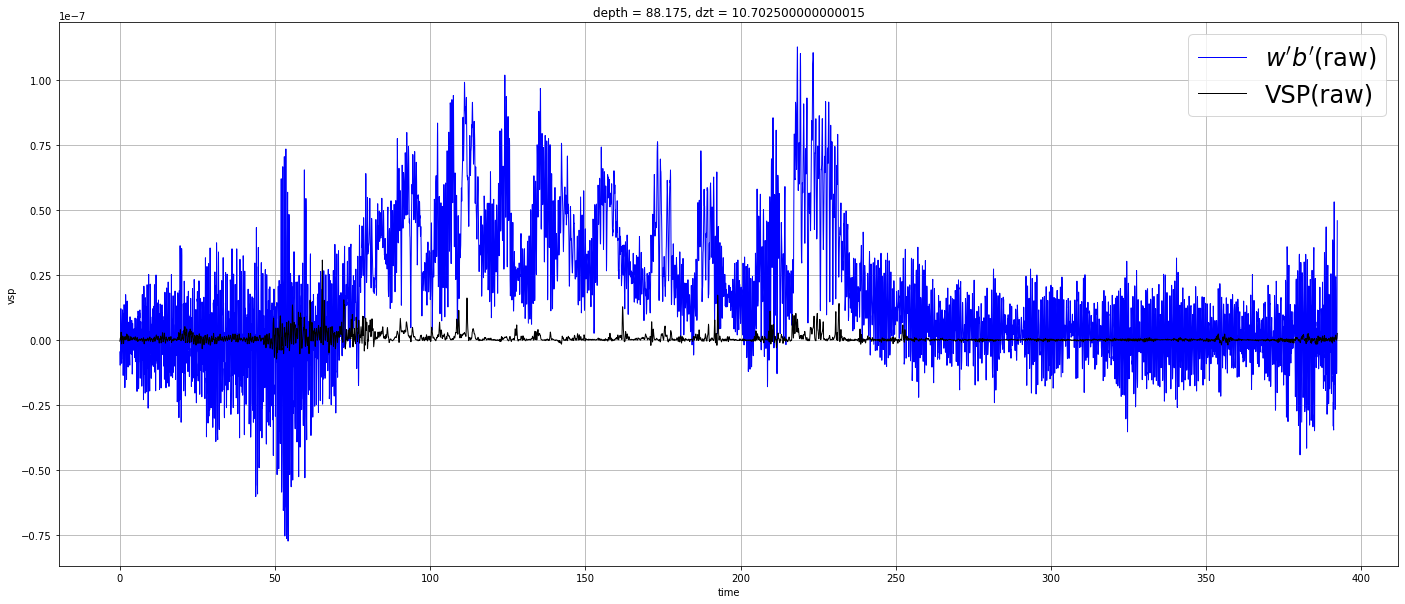

In [43]:
labels = ['VSP(raw)', '$w^\prime b^\prime$(raw)']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime.wb_prime.isel(depth=20).plot(ax=ax, color='blue', label=labels[1], linewidth=1)
vsp.vsp.isel(depth=20).plot(ax=ax, color='black', label=labels[0], linewidth=1)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

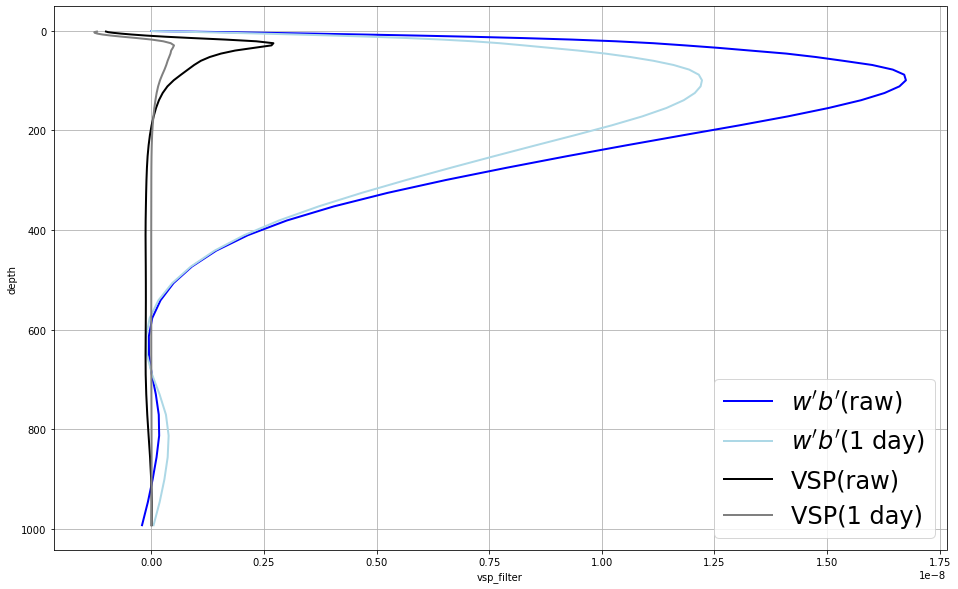

In [41]:
labels = ['VSP(raw)', '$w^\prime b^\prime$(raw)', 'VSP(1 day)', '$w^\prime b^\prime$(1 day)']

fig, ax = plt.subplots(figsize=(16,10))
wb_prime.wb_prime.mean('time').plot(ax=ax, color='blue', label=labels[1], linewidth=2, y='depth', yincrease=False)
wb_prime_filter.wb_prime_filter.mean('time').plot(ax=ax, color='lightblue', label=labels[3], linewidth=2, y='depth', yincrease=False)

vsp.vsp.mean('time').plot(ax=ax, color='black', label=labels[0], linewidth=2, y='depth', yincrease=False)
vsp_filter.vsp_filter.mean('time').plot(ax=ax, color='grey', label=labels[2], linewidth=2, y='depth', yincrease=False)

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

In [ ]:
cluster.close()